# Lecture 3: Introduction to Bayesian statistics and inference

#### This notebook was developed by [Zeljko Ivezic](http://faculty.washington.edu/ivezic/) for the 2023/24 data science class at the Rudjer Boskovic Institute, and it is available from [github](https://github.com/ivezic/RBI2023/blob/main/notebooks/Lecture3.ipynb).

Note: this notebook contains code developed by Z. Ivezic, M. Juric, A. Connolly, B. Sippocz, Jake VanderPlas, G. Richards, and many many others.

##### Additional resources for this notebook include:
 
- [Jake VanderPlas's workshop "Bayesian Astronomy"](https://github.com/jakevdp/BayesianAstronomy)
- [Jake VanderPlas's blog "Frequentism and Bayesianism: A Practical Introduction"](http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/)


##### Highly recommended supplemental background reading:

- [Jake VanderPlas: ``Frequentism and Bayesianism: A Python-driven Primer"](https://arxiv.org/abs/1411.5018)
- [Hogg, Bovy and Lang: ``Data analysis recipes: Fitting a model to data"](https://arxiv.org/abs/1008.4686)


##### For those who want to dive deep:

- [D. Sivia and J. Skilling: ``Data Analysis: A Bayesian Tutorial''](https://www.amazon.com/Data-Analysis-Bayesian-Devinderjit-Sivia/dp/0198568320)

<a id='toc'></a>

## This notebook includes:


[Bayes Rule extended to Bayesian Inference](#intro)

[The role of priors in Bayesian Inference](#prior)

[A simple parameter estimation example](#example) 

[Nuisance parameters and marginalization](#nuisance)

## Bayes Rule extended to Bayesian Inference <a id='intro'></a> 


![BayesSlide1](figures/bayes1.jpg)

## Recall Bayes' Rule

We had that 
$$p(x,y) = p(x|y)p(y) = p(y|x)p(x)$$

Btw, we also used notation ($p$ that both $A$ and $B$ will happen) 

$$p(A \cap B) \equiv p(A,B) = p(A|B)p(B) = p(B|A)p(A)$$

We can define the **marginal probability** as
$$p(x) = \int p(x,y)dy,$$
where marginal means essentially projecting on to one axis.

We can re-write this as
$$p(x) = \int p(x|y)p(y) dy$$


Since $$p(x|y)p(y) = p(y|x)p(x)$$ we can write that
$$p(y|x) = \frac{p(x|y)p(y)}{p(x)} = \frac{p(x|y)p(y)}{\int p(x|y)p(y) dy}$$
which in words says that

> the (conditional) probability of $y$ given $x$ is just the (conditional) probability of $x$ given $y$ times the (marginal) probability of $y$ divided by the (marginal) probability of $x$, where the latter is just the integral of the numerator.

This is **Bayes' rule**, which itself is not at all controversial -- it is just probability algebra!

What's more controversial is the **definition of probability**.

## Frequentist Probability
For frequentists, probability only has meaning in terms of **a limiting case of repeated measurements**.

That is, if I measure the photon flux $F$ from a given star (we'll assume for now that the star's flux does not vary with time), then measure it again, then again, and so on, each time I will get a slightly different answer due to the statistical error of my measuring device. In the limit of a large number of measurements, the frequency of any given value indicates the probability of measuring that value.

For frequentists **probabilities are fundamentally related to frequencies of events**. This means, for example, that **in a strict frequentist view, it is meaningless to talk about the probability of the true flux of the star: the true flux is (by definition) a single fixed value, and to talk about a frequency distribution for a fixed value is nonsense.**

## Bayesian Probability
For Bayesians, the concept of probability is extended to cover **degrees of certainty about statements**. You can think of it as an **extension of logic** to statements where there's uncertainty.

Say a Bayesian claims to measure the flux $F$ of a star with some probability $P(F)$: that probability can certainly be estimated from frequencies in the limit of a large number of repeated experiments, but this is not fundamental. The probability is a statement of my knowledge of what the measurement reasult will be.

For Bayesians, **probabilities are fundamentally related to our own knowledge about an event**. This means, for example, that **in a Bayesian view, we can meaningfully talk about the probability that the true flux of a star lies in a given range.**

That probability codifies our knowledge of the value based on prior information and/or available data.

## Why is this important?

Because it frees the Bayesian to ask a question such as:

* Given all I know (my measurements, the literature), what is the probability that a parameter $\theta$ is so-and-so?
* Given all I know (my measurements, the literature), what is the probability that a model is true?

And this is, intuitively, what a scientist wants to know.


![BayesSlide1](figures/bayes2.jpg)

### Recall Maximum Likelihood Estimation (MLE) applied to a Heteroscedastic Gaussian

For example, assume $N$ measurements, $\{x_i\}$, where the uncertainty for each measurement is Gaussian with
a known $\sigma_i$. The likelihood of one measurement is 

$$L \equiv p(x_i|\mu,\sigma_i) = \frac{1}{\sigma_i\sqrt{2\pi}} \exp\left(\frac{-(x_i-\mu)^2}{2\sigma_i^2}\right).$$


and therefore the likelihood of all N measurements is

$$L \equiv p(\{x_i\}|\mu,\sigma_i) = \prod_{i=1}^N \frac{1}{\sigma_i\sqrt{2\pi}} \exp\left(\frac{-(x_i-\mu)^2}{2\sigma_i^2}\right).$$



leading to (more convenient) log-likelihood

$$\ln L = {\rm constant} - \sum_{i=1}^N \frac{(x_i - \mu)^2}{2\sigma_i^2}.$$

Taking the derivative:
$$\frac{d\;{\rm lnL}(\mu)}{d\mu}\Biggr\rvert_{\mu_0} = \sum_{i=1}^N \frac{(x_i - \mu_o)}{\sigma_i^2} = 0,$$
then simplifying:

$$\sum_{i=1}^N \frac{x_i}{\sigma_i^2} = \sum_{i=1}^N \frac{\mu_o}{\sigma_i^2},$$

yields a MLE solution of 
$$\mu_0 = \frac{\sum_i^N (x_i/\sigma_i^2)}{\sum_i^N (1/\sigma_i^2)},$$

with uncertainty (from the second derivative)
$$\sigma_{\mu} = \left( \sum_{i=1}^N \frac{1}{\sigma_i^2}\right)^{-1/2}.$$

 

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm
np.random.seed(42)

In [2]:
### Let's draw a homoscedastic sample of {x_i} from a Gaussian and see what happens with L
# first generate a sample of N points drawn from N(mu,sigma):
sampleSize=3
mu = 1.0
sigma = 0.2 
sample = norm(mu, sigma).rvs(sampleSize) 
print(sample)

[1.09934283 0.97234714 1.12953771]


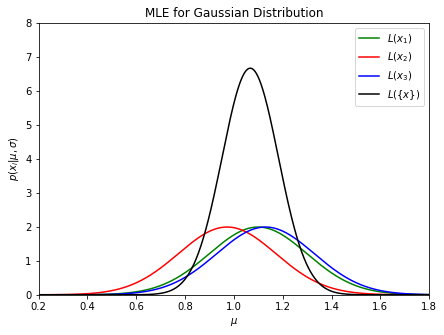

In [3]:
### Let's draw a homoscedastic sample of {x_i} from a Gaussian and see what happens with L
# now compute likelihoods for each point using true mu 
muGrid = np.linspace(0,2,1000)
L1 = norm(sample[0], sigma).pdf(muGrid) 
L2 = norm(sample[1], sigma).pdf(muGrid) 
L3 = norm(sample[2], sigma).pdf(muGrid) 
L = L1 * L2 * L3
# plot
fig, ax = plt.subplots(figsize=(7, 5))
plt.plot(muGrid, L1, ls='-', c='green', label=r'$L(x_1)$')
plt.plot(muGrid, L2, ls='-', c='red', label=r'$L(x_2)$')
plt.plot(muGrid, L3, ls='-', c='blue', label=r'$L(x_3)$')
plt.plot(muGrid, L, ls='-', c='black', label=r'$L(\{x\})$')

plt.xlim(0.2, 1.8)
plt.ylim(0, 8.0)
plt.xlabel('$\mu$')
plt.ylabel(r'$p(x_i|\mu,\sigma)$')
plt.title('MLE for Gaussian Distribution')
plt.legend()
plt.show() 

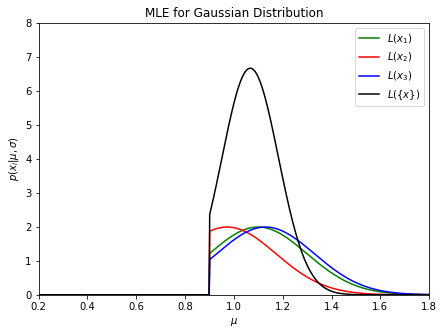

In [4]:
### What if I told you that mu>0.9?
muMin = 0.9
L1[muGrid < muMin] = 0
L2[muGrid < muMin] = 0
L3[muGrid < muMin] = 0
L = L1 * L2 * L3
# plot
fig, ax = plt.subplots(figsize=(7, 5))
plt.plot(muGrid, L1, ls='-', c='green', label=r'$L(x_1)$')
plt.plot(muGrid, L2, ls='-', c='red', label=r'$L(x_2)$')
plt.plot(muGrid, L3, ls='-', c='blue', label=r'$L(x_3)$')
plt.plot(muGrid, L, ls='-', c='black', label=r'$L(\{x\})$')

plt.xlim(0.2, 1.8)
plt.ylim(0, 8.0)
plt.xlabel('$\mu$')
plt.ylabel(r'$p(x_i|\mu,\sigma)$')
plt.title('MLE for Gaussian Distribution')
plt.legend()
plt.show() 

### Brief History 

The Reverend Thomas Bayes (1702–1761) was a British amateur mathematician who wrote a manuscript 
on how to combine an initial belief with new data to arrive at an improved belief. The manuscript 
was published posthumously in 1763 and gave rise to the name Bayesian statistics.  

The initial "belief" can be (and often is) based on data. For example, consider only the first (N-1)
measurements, instead of all N measurements as in 
$$\mu_0^{N} = \frac{\sum_i^N (x_i/\sigma_i^2)}{\sum_i^N (1/\sigma_i^2)},$$
which gives 
$$\mu_0^{N-1} = \frac{\sum_i^{N-1} (x_i/\sigma_i^2)}{\sum_i^{N-1} (1/\sigma_i^2)}.$$

Now, we can rewrite the expression for $\mu_0^{N}$ using the value of $\mu_0^{N-1}$, which 
we take to be our "intial belief", and the N-th measurement, $x_N$: 

$$\mu_0^{N} = \frac{(x_N/\sigma_N^2) + \sum_i^{N-1} (x_i/\sigma_i^2)}{\sum_i^{N-1} (1/\sigma_i^2)}
     * \frac{\sum_i^{N-1} (1/\sigma_i^2)}{\sum_i^N (1/\sigma_i^2)}  $$
     
$$\mu_0^{N} = \frac{(x_N/\sigma_N^2)}{\sum_i^{N} (1/\sigma_i^2)} + \mu_0^{N-1} 
     * \frac{\sum_i^{N-1} (1/\sigma_i^2)}{\sum_i^N (1/\sigma_i^2)}  $$

**This expression is a recipe for combining the prior belief, or knowledge ($\mu_0^{N-1}$), 
with the new measurement $x_N$. **

Given the inverse variance (squared uncertainty) $\sigma_\mu^{-2} = \sum_i^{N-1} (1/\sigma_i^2)$,
we also have 
$$\mu_0^{N} = \frac{(x_N/\sigma_N^2) + (\mu_0^{N-1}/\sigma_\mu^2)}{1/\sigma_N^2 + 1/\sigma_\mu^2}  $$

** The impact of each measurement is weighted by its inverse uncertainty squared. ** 

**A side note** This is an example of a conjugate prior. In special combinations 
of priors and likelihood functions, the posterior probability has the same functional 
form as the prior probability. These priors are called conjugate priors and represent 
a convenient way for generalizing computations. Here both prior and posterior pdfs
have the same functional form (Gaussian) because Gaussian prior and Gaussian likelihood
are conjugate prior (this is related to the fact that convolution of two Gaussians
gives a Gaussian).
 
The above expression greatly simplifies in case of homoscedastic errors 
($\sigma_\mu^{-2} = (N-1)/\sigma^2$): 

$$\mu_0^{N} = x_N * \frac{1}{N} + \mu_0^{N-1} * \frac{N-1}{N},  $$

which is a simple weighted sum of the prior value $\mu_0^{N-1}$ and the new value $x_N$. 


**Bayesian methodology allows us to derive analogous expressions in more complex and more general cases.**
  
 

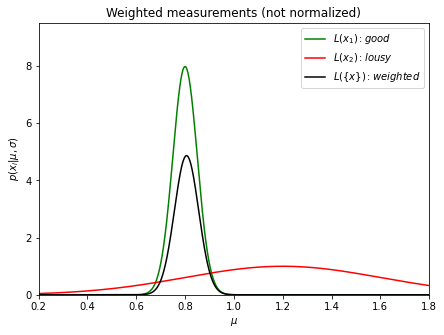

In [5]:
### What happens when we have one precise and one lousy measurement? 
L1 = norm(0.8, 0.05).pdf(muGrid) 
L2 = norm(1.2, 0.4).pdf(muGrid) 
L = L1 * L2 
# plot
fig, ax = plt.subplots(figsize=(7, 5))
plt.plot(muGrid, L1, ls='-', c='green', label=r'$L(x_1): good$')
plt.plot(muGrid, L2, ls='-', c='red', label=r'$L(x_2): lousy$')
plt.plot(muGrid, L, ls='-', c='black', label=r'$L(\{x\}): weighted$')

plt.xlim(0.2, 1.8)
plt.ylim(0, 9.5)
plt.xlabel('$\mu$')
plt.ylabel(r'$p(x_i|\mu,\sigma)$')
plt.title('Weighted measurements (not normalized)')
plt.legend()
plt.show() 
 

**If either of the two likelihoods (or one of the likelihood and prior pair) is 
the Dirac's $\delta$ function ("zero width"), the posterior is the same delta function.**
 

### Brief History 

The Reverend **Thomas Bayes** (1702–1761) was a British amateur mathematician who wrote a manuscript 
on how to combine an initial belief with new data to arrive at an improved belief. The manuscript 
was published posthumously in 1763 and gave rise to the name Bayesian statistics.  



### More brief History 

The first renowned mathematician to popularize Bayesian methodology was Pierre Simon Laplace, 
who rediscovered (1774) and greatly clarified Bayes' principle. Laplace applied the principle 
to a variety of contemporary problems in astronomy, physics, population statistics, and even 
jurisprudence. One of the most famous results is his estimate of the mass of Saturn and its 
uncertainty, which remain consistent with the best measurements of today. 

**Laplace said: "I find that it is a bet of 11,000 against one that the error of this result is not 1/100th 
of its value".** Therefore, Laplace clearly interpreted measurements as giving a probability
statement about the mass of Saturn, although there is only one Saturn and its true mass is 
what it is, and it is not a random variable according to frequentist statistics.

Despite Laplace's fame, Bayesian analysis did not secure a permanent place in science.
Instead, classical frequentist statistics was adopted as the norm (this could be at least
in part due to the practical difficulties of performing full Bayesian calculations without the
aid of computers). Much of Laplace's Bayesian analysis was ignored until the early twentieth
century when Harold Jeffreys reinterpreted Laplace's work with much clarity. 
Yet, even Jeffreys' work was not fully comprehended until around 1960, when it took off thanks
to vocal proponents such as de Finetti, Savage, Wald, and Jaynes, and of course, the advent of
computing technology. 
 

### An example of a difficulty with the MLE 

Imagine you arrive at a bus stop, and observe that the bus arrives $t$ minutes later 
(it is assumed that you had no knowledge about the bus schedule). What is the mean time 
between two successive buses, $\tau$, if the buses keep a regular schedule? 

It is easy to derive an intuitive answer. The wait time is distributed uniformly in the interval $0 \le t \le \tau$, and on average you would wait for $t=\tau/2$ minutes.  Rearranging this gives $\tau = 2t$, which agrees with intuition.

What does the maximum likelihood approach give? 

The probability that you will wait $t$ 
minutes (the likelihood of data) is given by the uniform distribution (every $t$ is equally likely)
$$ p(t\,|\,\tau) =  1/\tau, $$
if $0 \le t \le \tau$ and $p(t|\tau)=0$ otherwise.


Because we only observe a single point, the data likelihood is simply equal to this probability. 
The maximum likelihood, then, corresponds to the smallest possible $\tau$ such that $t \le \tau$: 
this is satisfied by $\tau = t$ and not $\tau=2t$ as we expected!!

Computing the expectation value or the median for $\tau$ does not help either because
the resulting integrals diverge. These puzzling results are resolved by the use of appropriate prior
information, as will be discussed in a moment. We shall see several other examples later where the
addition of extra information changes the results we would get from the maximum likelihood
approach.

Let's first introduce basic steps in Bayesian analysis, then use it to resolve
the "bus MLE puzzle", and then we'll discsus nuisance parameters in more details. 
 

## Bayesian Statistical Inference

Up to now we have been computing the **likelihood** $p(D\,|\,M)$.  In Bayesian inference, we instead evaluate the **posterior probability** taking into account **prior** information.

Recall that Bayes' Rule is:
$$p(M\,|\,D) = \frac{p(D\,|\,M)\,p(M)}{p(D)},$$
where $D$ is for data and $M$ is for model. Or in words, 
$${\rm Posterior \,\, Probability} = \frac{{\rm Likelihood}\times{\rm Prior}}{{\rm Evidence}}.$$

If we explicitly recognize prior information, $I$, and the model parameters, $\theta$, then we can write:
$$p(M,\theta \,|\,D,I) = \frac{p(D\,|\,M,\theta,I)\,p(M,\theta\,|\,I)}{p(D\,|\,I)},$$
where we will omit the explict dependence on $\theta$ by writing $M$ instead of $M,\theta$ where appropriate.  However, as the prior can be expanded to 
$$p(M,\theta\,|\,I) = p(\theta\,|\,M,I)\,p(M\,|\,I),$$
it will still appear in the term $p(\theta\,|\,M,I)$.

Note that it is often the case that $p(D\,|\,I)$ is not evaluated explictly since the posterior probability 
can be (re)normalized. 

**The Bayesian Statistical Inference process** is then
* formulate the likelihood, $p(D\,|\,M,\theta,I)$
* chose a prior$^1$, $p(M,\theta\,|\,I)$, which incorporates *other information beyond the data in $D$*
* determine the posterior pdf, $p(M,\theta \,|\,D,I)$
* search for the model parameters that maximize $p(M,\theta \,|\,D,I)$ 
* quantify the uncertainty of the model parameter estimates
 
$^1$: Note that $p(M,\theta\,|\,I) = p(\theta\,|\,M, I)\, p(M\,|\,I)$.  

Going back to our bus arrival problem, our unknown model parameter is $\tau$ and data is $t$, so that 
$$p(\tau\,|\,t,I) = p(t\,|\,\tau) \, p(\tau\,|\,I).$$

Before applying this expression, we need to discuss how to choose priors, here $p(\tau\,|\,I)$.

## Bayesian Priors <a id='priors'></a>
[Go to top](#toc)



Priors can be **informative** or **uninformative**.  As it sounds, informative priors are based on existing information (including previously obtained data, but not the data considered right now) that might be available.  Uniformative priors can be thought of as "default" priors, i.e., what your prior is when you never used
any data, e.g, a "flat" prior like $p(\theta|M,I) \propto {\rm C}$.

Detailed discussion can be found in Section 5.2 in the textbook. There are three
main principles used to choose a prior: 


#### The Principle of Indifference

Essentially this means adopting a uniform prior, though you have to be a bit careful.  Saying that an asteroid is equally likely to hit anywhere on the Earth is not the same as saying that all latitudes of impact are equally likely.  

Assuming $1/6$ for a six-side die, or 1/2 for heads and tails of a fair coin, would be an example of indifference.

#### The Principle of Invariance (or Consistency)

This applies to location and scale invariance.  

**Location invariance** suggests a uniform prior, within the accepted bounds: $p(\theta|I) \propto 1/(\theta_{max}-\theta_{min})$ for $\theta_{min} \le \theta \le \theta_{max}$. 

**Scale invariance** gives us priors that look like $p(\theta|I) \propto 1/\theta$, which implies a uniform
prior for ln($\theta$). 

#### The Principle of Maximum Entropy

We will not discuss it here - for more details, see Section 5.2.2 in the textbook.
 
It is often true that Bayesian analysis and traditional MLE are essentially equivalent.  
However, in some cases, considering the priors can have significant consequences, as
we will see later. 

We will skip examples of very steep priors and their consequences called in astronomy
literature **Eddington-Malmquist** and **Lutz-Kelker** biases (see Chapter 5 in the textbook
if you are interested). 

Now, let's go back to the bus arrival problem. 

## A simple parameter estimation example <a id='example'></a>
[Go to top](#toc)

In our **bus arrival problem**, $\tau$ is unknown model parameter and data (datum) is $t$. The
posterior pdf for $\tau$ is (we ignore normalization): 
$$p(\tau\,|\,t, I) \propto p(t\,|\,\tau,I) \, p(\tau\,|\,I).$$

The likelihood of data is given by the uniform distribution (every $t$ is equally likely, with 
$0 \le t \le \tau$):
$$ p(t\,|\,\tau,I) =  1/\tau. $$  

Following the Principle of Invariance, we assign the prior
$$ p(\tau\,|\,I) = 1/ \tau.$$

Note: the two pdfs look the same but this is essentially a coincidence. 

So, we have 
    $$p(\tau \,|\, t,I) \propto  1/ \tau^2,$$
for $\tau > t$ and 0 otherwise. We use normalization constraint 
$$ \int_t^\infty p(\tau\,|\,I)d\tau = \int_t^\infty C/\tau^2 d\tau \equiv 1,$$
to get $C=t$ (the divergent integral over $\tau$ encountered in the maximum likelihood 
analysis is mitigated here by the extra $\tau$ term from the prior).

The properly normalized posterior pdf for $\tau$ (valid for $\tau > t$) is thus 
$$   p(\tau \,|\, t,I) = \frac{t}{\tau^2}.$$
  
  
The median $\tau$ given by the posterior $p(\tau \,|\, t,I)$ is now equal to $2t$, 
in agreement with our expectations. 

An interesting side result is that the p% quantiles 
are equal to ($1-t/\tau$); for example, the 95% confidence region for $\tau$, 
or **the credible region**, spans $1.03 t < \tau < 40 t$. If we waited for a bus 
for just 1 minute, then, adopting the usual 95% confidence region, we cannot reject the 
possibility that $\tau$ is as large as 40 minutes. 

Equivalently, if we waited for a 
bus for 1 minute, we can paraphrase Laplace and say that “it is a bet of 20 against 1 
that the bus will arrive in the interval between 0.03 minutes and 39 minutes from now.”





## Nuisance parameters and marginalization: heteroscedastic Gaussian as an example <a id='nuisance'></a>
[Go to top](#toc)


Consider the case of measuring a rod.  We want to know the posterior pdf for the length of the rod, $p(M,\theta|D,I) \equiv p(\mu|\{x_i\},\{\sigma_i\},I)$.

For the likelihood we have
$$L = p(\{x_i\}|\mu,I) = \prod_{i=1}^N \frac{1}{\sigma_i\sqrt{2\pi}} \exp\left(\frac{-(x_i-\mu)^2}{2\sigma_i^2}\right).$$

**In the Bayesian case, we also need a prior.**  We'll adopt a uniform distribution given by
$$p(\mu|I) = C, \; {\rm for} \; \mu_{\rm min} < \mu < \mu_{\rm max},$$
where $C = \frac{1}{\mu_{\rm max} - \mu_{\rm min}}$ between the min and max and is $0$ otherwise.

The log of the posterior pdf is then
$$\ln L = {\rm constant} - \sum_{i=1}^N \frac{(x_i - \mu)^2}{2\sigma_i^2}.$$

This is exactly the same as we saw before, except that the value of the constant is different.  Since the constant doesn't come into play, we get the same result as before:
 
$$\mu^0 = \frac{\sum_i^N (x_i/\sigma_i^2)}{\sum_i^N (1/\sigma_i^2)},$$
with uncertainty
$$\sigma_{\mu} = \left( \sum_{i=1}^N \frac{1}{\sigma_i^2}\right)^{-1/2}.$$
 
 We get the same result because we used a flat prior. If the case were homoscedastic instead of heteroscedastic, we obviously would get the result from our first example.



### Nuisance parameters and marginalization: heteroscedastic Gaussian as an example


Now let's consider the case where **$\sigma$ is not known**, but rather it needs to be determined from the data, too.

In this case, the posterior pdf that we seek is not $p(\mu|\{x_i\},\{\sigma_i\},I)$, but rather $p(\mu,\sigma|\{x_i\},I)$.

As before we have
$$L = p(\{x_i\}|\mu,\sigma,I) = \prod_{i=1}^N \frac{1}{\sigma\sqrt{2\pi}} \exp\left(\frac{-(x_i-\mu)^2}{2\sigma^2}\right),$$
except that now $\sigma$ is uknown.

Our Bayesian prior is now 2D instead of 1D and we'll adopt 
$$p(\mu,\sigma|I) \propto \frac{1}{\sigma},\; {\rm for} \; \mu_{\rm min} < \mu < \mu_{\rm max} \; {\rm and} \; \sigma_{\rm min} < \sigma < \sigma_{\rm max}.$$

With proper normalization, we have
$$p(\{x_i\}|\mu,\sigma,I)p(\mu,\sigma|I) = C\frac{1}{\sigma^{(N+1)}}\prod_{i=1}^N \exp\left( \frac{-(x_i-\mu)^2}{2\sigma^2}  \right),$$
where
$$C = (2\pi)^{-N/2}(\mu_{\rm max}-\mu_{\rm min})^{-1} \left[\ln \left( \frac{\sigma_{\rm max}}{\sigma_{\rm min}}\right) \right]^{-1}.$$

The log of the posterior pdf is

$$\ln[p(\mu,\sigma|\{x_i\},I)] = {\rm constant} - (N+1)\ln\sigma - \sum_{i=1}^N \frac{(x_i - \mu)^2}{2\sigma^2}.$$

Right now that has $x_i$ in it, which isn't that helpful, but since we are assuming a Gaussian distribution, we can take advantage of the fact that the mean, $\overline{x}$, and the variance, $V (=s^2)$, completely characterized the distribution.  So we can write this expression in terms of those variables instead of $x_i$.  Skipping over the math details (see textbook $\S$5.6.1), we find

$$\ln[p(\mu,\sigma|\{x_i\},I)] = {\rm constant} - (N+1)\ln\sigma - \frac{N}{2\sigma^2}\left( (\overline{x}-\mu)^2 + V  \right).$$

Note that this expression only contains the 2 parameters that we are trying to determine: $(\mu,\sigma)$ and 3 values that we can determine directly from the data: $(N,\overline{x},V)$. A side note: these three data-based values 
fully encapsulate our dataset and are called *sufficient statistics*.

Load and execute the next cell to visualize the posterior pdf for the case of $(N,\overline{x},V)=(10,1,4)$.  Remember to change `usetex=True` to `usetex=False` if you have trouble with the plotting.  Try changing the values of $(N,\overline{x},V)$. 
 

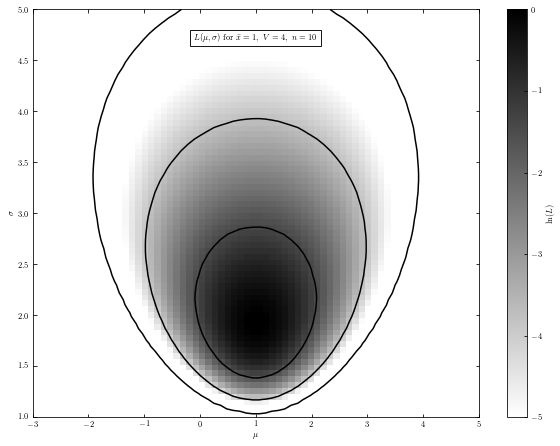

In [6]:
"""
Log-likelihood for Gaussian Distribution
----------------------------------------
Figure5.4
An illustration of the logarithm of the posterior probability density
function for :math:`\mu` and :math:`\sigma`, :math:`L_p(\mu,\sigma)`
(see eq. 5.58) for data drawn from a Gaussian distribution and N = 10, x = 1,
and V = 4. The maximum of :math:`L_p` is renormalized to 0, and color coded as
shown in the legend. The maximum value of :math:`L_p` is at :math:`\mu_0 = 1.0`
and :math:`\sigma_0 = 1.8`. The contours enclose the regions that contain
0.683, 0.955, and 0.997 of the cumulative (integrated) posterior probability.
"""
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt
from astroML.plotting.mcmc import convert_to_stdev

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)


def gauss_logL(xbar, V, n, sigma, mu):
    """Equation 5.57: gaussian likelihood"""
    return (-(n + 1) * np.log(sigma)
            - 0.5 * n * ((xbar - mu) ** 2 + V) / sigma ** 2)

#------------------------------------------------------------
# Define the grid and compute logL
sigma = np.linspace(1, 5, 70)
mu = np.linspace(-3, 5, 70)
xbar = 1
V = 4
n = 10

logL = gauss_logL(xbar, V, n, sigma[:, np.newaxis], mu)
logL -= logL.max()

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(10, 7.5))
plt.imshow(logL, origin='lower',
           extent=(mu[0], mu[-1], sigma[0], sigma[-1]),
           cmap=plt.cm.binary,
           aspect='auto')
plt.colorbar().set_label(r'$\ln(L)$')
plt.clim(-5, 0)

plt.contour(mu, sigma, convert_to_stdev(logL),
            levels=(0.683, 0.955, 0.997),
            colors='k')

plt.text(0.5, 0.93, r'$L(\mu,\sigma)\ \mathrm{for}\ \bar{x}=1,\ V=4,\ n=10$',
         bbox=dict(ec='k', fc='w', alpha=0.9),
         ha='center', va='center', transform=plt.gca().transAxes)

plt.xlabel(r'$\mu$')
plt.ylabel(r'$\sigma$')

plt.show()

### Nuisance parameters and marginalization: heteroscedastic Gaussian as an example
 
The plot from the previous cell is described by 
$$\ln[p(\mu,\sigma|\{x_i\},I)] = {\rm constant} - (N+1)\ln\sigma - \frac{N}{2\sigma^2}\left( (\overline{x}-\mu)^2 + V  \right).$$
 
 
**A side note:** Had we assumed a uniform distribution of $\sigma$, instead of ln($\sigma$), then the factor multiplying ln($\sigma$) would change from (N + 1) to N. This is related to the fact that the expression for
the standard deviation has a term (N-1) rather than N.

Assume a case where $\sigma$ is not crucially important to what we are after, e.g. it may 
simply represent how good our measuring apparatus is - what we might get a Nobel prize for 
is $\mu$. Therefore, what we want is $p(\mu|\{x_i\},I)$, rather than $p(\mu,\sigma|\{x_i\},I)$.
We can get the former from the latter by the **marginalization over $\sigma$**, which means
integration of $p(\mu,\sigma|\{x_i\},I)$ over $\sigma$: 

$$ p(\mu\,|\,\{x_i\},I) = \int_0^\infty p(\mu,\sigma|\{x_i\},I) d\sigma$$
and thus (using the substitution $t$ = 1/$\sigma$ and integration by parts)

$$ p(\mu\,|\,\{x_i\},I) \propto \left(1 + \frac{(\overline{x}-\mu)^2}{V} \right)^{-N/2}. $$

It is easy to show that this result corresponds to Student’s t distribution (google it!) with 
k = N-1 degrees of freedom for the variable $t = (x-\mu)/(s/\sqrt{N})$, where $s$ is the sample 
standard deviation. Student’s t distribution is symmetric and bell shaped, but with heavier 
tails than for a Gaussian distribution.  

**Hold on!** This is not a Gaussian distribution promised by the Central Limit Theorem!!! 

That's fine! The CLT promised a Gaussian only for large N. Indeed, the above expression
(Student's t distribution) morphs into a Gaussian for large N - let's check!



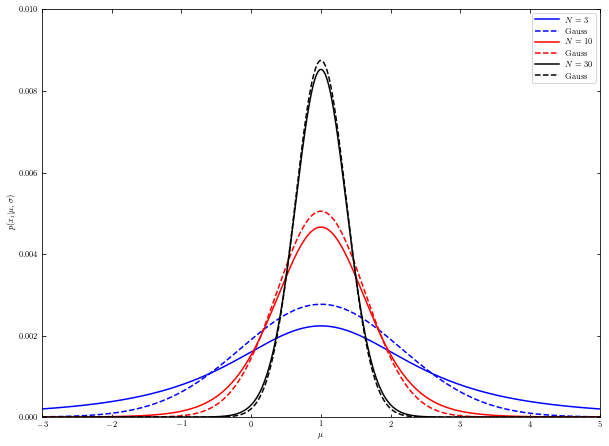

In [7]:
### let's see how Student's t distribution morphs into Gaussian distribution
# let's first choose mean x and variance as in the previous example
mu = np.linspace(-3, 5, 1000)
xbar = 1.0
V = 4.0

# and now let's generate p(mu) for N=3, 10 and 20
def compute_pmu(mu, xbar, V, N):
    p = (1 + (xbar - mu) ** 2 / V) ** (-0.5 * N)
    return p / np.sum(p)
#
N1 = 3
pmu1 = compute_pmu(mu,xbar,V,N1)
G1 = norm(xbar, np.sqrt(V/N1)).pdf(mu) 
G1norm = G1 / np.sum(G1)
N2 = 10
pmu2 = compute_pmu(mu,xbar,V,N2)
G2 = norm(xbar, np.sqrt(V/N2)).pdf(mu) 
G2norm = G2 / np.sum(G2)
N3 = 30
pmu3 = compute_pmu(mu,xbar,V,N3)
G3 = norm(xbar, np.sqrt(V/N3)).pdf(mu) 
G3norm = G3 / np.sum(G3)
 
## plot
fig, ax = plt.subplots(figsize=(10, 7.5))
plt.plot(mu, pmu1, ls='-', c='blue', label=r'$N=3$')
plt.plot(mu, G1norm, ls='--', c='blue', label=r'Gauss')
plt.plot(mu, pmu2, ls='-', c='red', label=r'$N=10$')
plt.plot(mu, G2norm, ls='--', c='red', label=r'Gauss')
plt.plot(mu, pmu3, ls='-', c='black', label=r'$N=30$')
plt.plot(mu, G3norm, ls='--', c='black', label=r'Gauss')

plt.xlim(-3, 5)
plt.ylim(0, 0.01)
plt.xlabel('$\mu$')
plt.ylabel(r'$p(x_i|\mu,\sigma)$')
plt.legend()
plt.show() 

[Go to top](#toc)

### Marginal distributions $p(\mu)$ and $p(\sigma)$

The top panels of the figure below (textbook figure 5.5, for the code see 
[astroML website](http://www.astroml.org/book_figures/chapter5/fig_posterior_gaussian.html)) show marginal distributions $p(\mu)$ and $p(\sigma)$.  The solid line is 
analytic Bayesian result with uninformative prior and the dotted line is the result for a uniform prior (note 
that there is not that much difference).  The dashed line is the MLE result, which is quite different.  The bottom panels show the cumulative distributions.

![Ivezic, Figure 5.5](figures/fig_posterior_gaussian_1.png)
 

[Go to top](#toc)